In [58]:
import pandas as pd
import xarray as xr
import datetime as dt
import json
import pytz
#first import the relevant python packages

import numpy as np
import os 
import urllib
import matplotlib.pyplot as plt

from pysolar.solar import *

# User inputs

In [59]:
datelist_winter = ['20230110', '20230111', '20230112', '20230113', '20230114']
datelist_spring = ['20230407', '20230408', '20230409', '20230410', '20230411']
local_download_dir = '../data/sosnoqc/'

# Define some helper functions

In [60]:
def download_sos_data_day(date, local_download_dir, cache=True):
    """Download a netcdf file from the ftp url provided by the Earth Observing 
    Laboratory at NCAR. Data comes in one NetCDF file per day, Reynolds-Averaged 
    with a 5-minute averaging period.

    Args:
        date (str, optional): String representing a date in format '%Y%m%d'. Defaults to '20221101'.
        local_download_dir (str, optional): Directory to which files will be downloaded. Defaults 
                    to 'sosnoqc'; this directory will be created if it  does not already exist.
        cache (bool, optional): If True, looks in `local_download_dir` for requested  file, if it 
                    exists, does not redownload file. If False, downloads file from the FTP server.

    Returns:
        _type_: Relative path to the downloaded file
    """
    base_url = 'ftp.eol.ucar.edu'
    path = 'pub/archive/isfs/projects/SOS/netcdf/noqc_geo'
    file = f'isfs_{date}.nc'
    os.makedirs(local_download_dir, exist_ok=True)
    full_file_path = os.path.join('ftp://', base_url, path, file)
    download_file_path = os.path.join(local_download_dir, file)
    if cache and os.path.isfile(download_file_path):
        print(f"Caching...skipping download for {date}")
    else:
        urllib.request.urlretrieve(
            full_file_path,
            download_file_path   
        )
    return download_file_path

# Download data

## SoS data

In [61]:
files_spring = [download_sos_data_day(d, local_download_dir) for d in datelist_spring]
sos_datasets_spring = [xr.open_dataset(f) for f in files_spring]
sos_ds_spring = xr.concat(sos_datasets_spring, dim='time')

files_winter = [download_sos_data_day(d, local_download_dir) for d in datelist_winter]
sos_datasets_winter = [xr.open_dataset(f) for f in files_winter]
sos_ds_winter = xr.concat(sos_datasets_winter, dim='time')

Caching...skipping download for 20230407
Caching...skipping download for 20230408
Caching...skipping download for 20230409
Caching...skipping download for 20230410
Caching...skipping download for 20230411
Caching...skipping download for 20230110
Caching...skipping download for 20230111
Caching...skipping download for 20230112


### Do some calculations

In [62]:
SIGMA = 5.67e-8 # Stephan-Boltzmann Constant
sos_ds_spring = sos_ds_spring.assign(
    LWout = (sos_ds_spring.Rpile_out_9m_d + (sos_ds_spring.Tcase_out_9m_d+273.15)**4*SIGMA),          
    LWin = (sos_ds_spring.Rpile_in_9m_d + (sos_ds_spring.Tcase_out_9m_d+273.15)**4*SIGMA)
)
sos_ds_winter = sos_ds_winter.assign(
    LWout = (sos_ds_winter.Rpile_out_9m_d + (sos_ds_winter.Tcase_out_9m_d+273.15)**4*SIGMA),          
    LWin = (sos_ds_winter.Rpile_in_9m_d + (sos_ds_winter.Tcase_out_9m_d+273.15)**4*SIGMA)
)

In [63]:
VARIABLES = ['Rsw_in_9m_d',
            'Rsw_out_9m_d',
            'LWout',
            'LWin']

sos_ds_spring = sos_ds_spring[VARIABLES]
sos_ds_winter = sos_ds_winter[VARIABLES]

### Create 30min resampled dataset

In [64]:
sos_ds_spring_30min = sos_ds_spring.resample(time='30Min').mean()
sos_ds_winter_30min = sos_ds_winter.resample(time='30Min').mean()

## Precipitation data

In [65]:
precip_xr = xr.open_dataset('../modules/data/precipitation.nc')
precip_df = precip_xr.to_dataframe().reset_index()
precip_df['daily_precip'] = precip_df['acc_prec'].diff().fillna(0)
precip_df = precip_df[(precip_df.date >= dt.datetime.strptime(datelist_winter[0], '%Y%m%d')) & (precip_df.date <= dt.datetime.strptime(datelist_winter[-1], '%Y%m%d'))]


# Problem 3: Dust on snow and albedo

We know that the reflectivity of snow, termed albedo, calculated as outgoing-solar-radiation divided by incoming-solar-radiation, is brightest right after new snowfall and then darkens as snow ages. This occurs both as a process of snow grains rounding and growing and as snow gets dirtier with deposition. In early April, a substantial amount of dust was deposited on our site at Kettle Ponds (see the photo at the top of this page). Using the Kettle Ponds radiation dataset, investigate how albedo changes both with time after a new snowfall event earlier in the winter (no dust) and in mid-April (with dust). How much does dust impact albedo compared to the natural snow aging process?

In [66]:
sos_ds_spring_30min['albedo'] = sos_ds_spring_30min['Rsw_out_9m_d']/sos_ds_spring_30min['Rsw_in_9m_d']
sos_ds_winter_30min['albedo'] = sos_ds_winter_30min['Rsw_out_9m_d']/sos_ds_winter_30min['Rsw_in_9m_d']

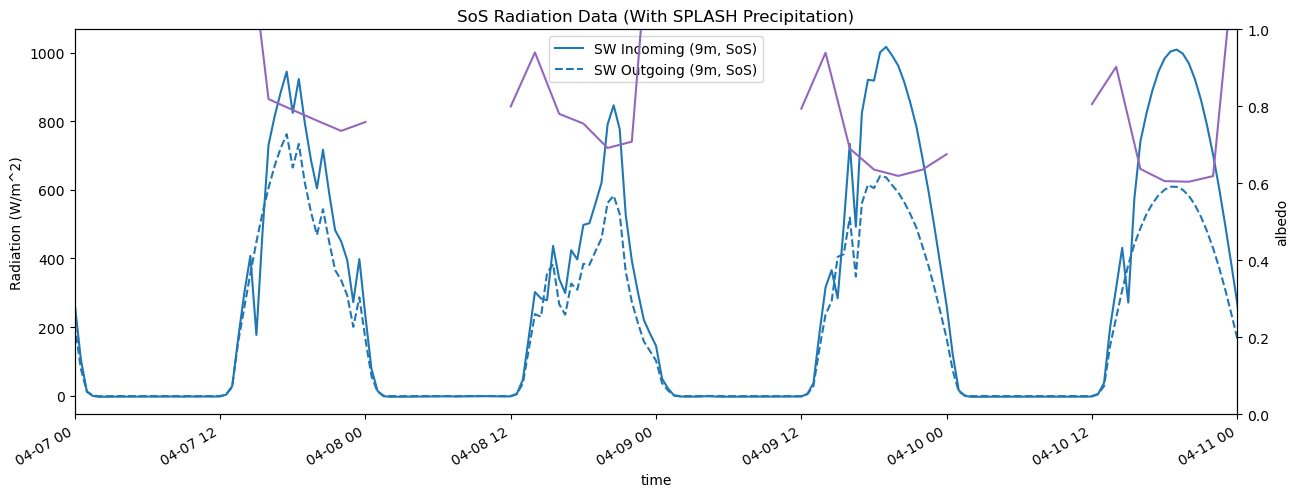

In [67]:
fix, ax1 = plt.subplots(1, 1, figsize=(15,5), sharex=True)

sos_ds_spring_30min['Rsw_in_9m_d'].plot(label='SW Incoming (9m, SoS)', ax=ax1, color='tab:blue')
sos_ds_spring_30min['Rsw_out_9m_d'].plot(label='SW Outgoing (9m, SoS)', ax=ax1, color='tab:blue', linestyle='--')

ax1_twin = ax1.twinx()
sos_ds_spring_30min.where(sos_ds_spring_30min['Rsw_in_9m_d'] > 0).resample(time='120Min').mean()['albedo'].plot(label='Albedo', ax=ax1_twin, color='tab:purple')
ax1_twin.set_ylim(0,1)

ax1.set_ylabel("Radiation (W/m^2)")

ax1.set_title("SoS Radiation Data (With SPLASH Precipitation)")
plt.xlim(dt.datetime.strptime(datelist_spring[0], '%Y%m%d'), dt.datetime.strptime(datelist_spring[-1], '%Y%m%d'))
ax1.legend()

(19367.0, 19371.0)

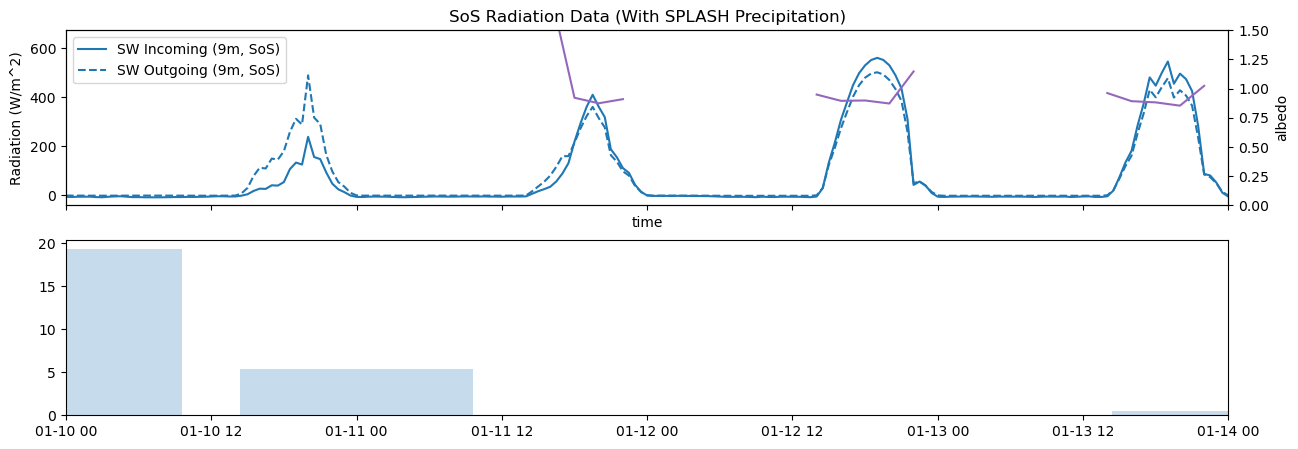

In [71]:
fix, [ax1, ax2] = plt.subplots(2, 1, figsize=(15,5), sharex=True)

sos_ds_winter_30min['Rsw_in_9m_d'].plot(label='SW Incoming (9m, SoS)', ax=ax1, color='tab:blue')
sos_ds_winter_30min['Rsw_out_9m_d'].plot(label='SW Outgoing (9m, SoS)', ax=ax1, color='tab:blue', linestyle='--')

ax1_twin = ax1.twinx()
sos_ds_winter_30min.where(sos_ds_winter_30min['Rsw_in_9m_d'] > 0).resample(time='120Min').mean()['albedo'].plot(label='Albedo', ax=ax1_twin, color='tab:purple')
ax1_twin.set_ylim(0,1.5)
ax1.set_ylabel("Radiation (W/m^2)")
ax1.set_title("SoS Radiation Data (With SPLASH Precipitation)")
ax1.legend()

ax2.bar(precip_df['date'], precip_df['daily_precip'], alpha=0.25)

plt.xlim(dt.datetime.strptime(datelist_winter[0], '%Y%m%d'), dt.datetime.strptime(datelist_winter[-1], '%Y%m%d'))